In [1]:
import numpy as np
import statsmodels.api as sm
from statsmodels.tools import add_constant
from matplotlib import pyplot

True model is

$$
\mathbb{E}[Y|X,Z] = \delta_p X + p_{\mathrm{hi}}Z+(1-Z)p_{\mathrm{lo}}
$$

$X$ is the treatment variable, $Z$ the covariate. Both $X$ and $Z$ are independent Bernoulli variables with probability of $1$ equal to $\tfrac{1}{2}$.

In [2]:
ntrials = 1000 # number of times to run the experiment
n = 10000 # number of samples from the population per experiment

p_hi = 0.8 # probability of success in the high probability subpopulation
p_lo = 0.2 # probability of success in the low probability subpopulation
delta_p = 0.05 # effect size

# probability of success under treatment
P_T = delta_p + 0.5*p_hi+0.5*p_lo
# probability of success under control
P_C = 0.5*p_hi+0.5*p_lo

pop_log_odds = np.log(P_T/(1-P_T))-np.log(P_C/(1-P_C))
print("Population log odds = {:.2f}".format(pop_log_odds))
print("Population odds ratio = {:.2f}".format(np.exp(pop_log_odds)))

Population log odds = 0.20
Population odds ratio = 1.22


In [3]:
'''
Run ntrials experiments where we sample n individuals from the population, fit a logistic model predicting Y 
from (X,Z), and then using the coefficient of X as an estimate of the log odds. Display the average point 
estimate and the frequency in which the true log odds falls in the 95% confidence interval. Also compute a 
plug-in estimate of the log odds for comparison.
'''

success_count=np.zeros(ntrials)
beta_est = np.empty(ntrials)
logistic_odds_ratio_est = np.empty(ntrials)
plug_in_odds_ratio_est= np.empty(ntrials)

for i in range(ntrials):
    # generate covariate and treatment variables and compute conditional outcome probabilities
    covariate = np.random.binomial(1,0.5,n)
    treatment = np.random.binomial(1,0.5,n)
    prob = delta_p*treatment + (p_hi-p_lo)*covariate + p_lo
    
    # generate outcomes
    outcome = np.random.binomial(1, prob)

    # run logistic regression and compute confidence intervals
    features = add_constant(np.hstack((treatment[:,None],covariate[:,None])))
    model = sm.Logit(outcome, features).fit(disp=0)

    beta_est[i] = model.params[1]
    logistic_odds_ratio_est[i] = np.exp(model.params[1])
    lower_int = model.conf_int(alpha=0.05, cols=None)[1,0]   
    if lower_int<pop_log_odds:
        success_count[i]=1
    
    # plugin estimator
    P_T_est = np.sum(treatment*outcome)/np.sum(treatment)
    P_C_est = np.sum((1-treatment)*outcome)/np.sum(1-treatment)  
    plug_in_odds_ratio_est[i]= np.log(P_T_est/(1-P_T_est))-np.log(P_C_est/(1-P_C_est))

print("L O G I S T I C   R E G R E S S I O N")
print("------------------------------------------")
print("Median estimate of treatment coefficient = {:.2f}".format(np.median(beta_est)))
print("Median estimated odds ratio from logistic = {:.2f}".format(np.median(logistic_odds_ratio_est)))
print("Confidence interval contains population log-odds {:.0f}% of the time".format(100*np.mean(success_count)))

print("\n\nP L U G I N   E S T I M A T O R")
print("------------------------------------------")
print("Median plugin estimate of log odds = {:.2f}".format(np.median(plug_in_odds_ratio_est)))
print("Median estimated odds ratio from plugin = {:.2f}".format(np.median(np.exp(plug_in_odds_ratio_est))))

L O G I S T I C   R E G R E S S I O N
------------------------------------------
Median estimate of treatment coefficient = 0.31
Median estimated odds ratio from logistic = 1.37
Confidence interval contains population log-odds 38% of the time


P L U G I N   E S T I M A T O R
------------------------------------------
Median plugin estimate of log odds = 0.20
Median estimated odds ratio from plugin = 1.22


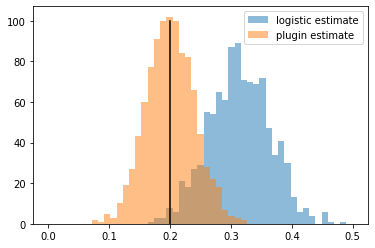

In [4]:
bins = np.linspace(0, .5, 50)

pyplot.hist(beta_est, bins, alpha=0.5, label='logistic estimate')
pyplot.hist(plug_in_odds_ratio_est, bins, alpha=0.5, label='plugin estimate')
pyplot.plot([0.2,0.2],[0,100],color=[0,0,0])
pyplot.legend(loc='upper right')
pyplot.show()